In [2]:
%matplotlib inline
from matplotlib.pyplot import *
import numpy as np
from scipy.linalg import svd

# This is a robust PCA implementation, adapted from 
https://github.com/dfm/pcp/blob/master/pcp.py

In [4]:
import time
import logging
import numpy as np
from scipy.sparse.linalg import svds

def pcp(M, delta=1e-6, mu=None, maxiter=500, verbose=False, missing_data=True,
        svd_method = "exact", **svd_args):
    # Check the SVD method.a
    allowed_methods = ["exact", "sparse"]
    if svd_method not in allowed_methods:
        raise ValueError("'svd_method' must be one of: {0}"
                         .format(allowed_methods))

    # Check for missing data.
    shape = M.shape
    if missing_data:
        missing = ~(np.isfinite(M))
        if np.any(missing):
            M = np.array(M)
            M[missing] = 0.0
    else:
        missing = np.zeros_like(M, dtype=bool)
        if not np.all(np.isfinite(M)):
            logging.warn("The matrix has non-finite entries. "
                         "SVD will probably fail.")

    # Initialize the tuning parameters.
    lam = 1.0 / np.sqrt(np.max(shape))
    if mu is None:
        mu = 0.25 * np.prod(shape) / np.sum(np.abs(M))
        if verbose:
            print("mu = {0}".format(mu))

    # Convergence criterion.
    norm = np.sum(M ** 2)

    # Iterate.
    i = 0
    rank = np.min(shape)
    S = np.zeros(shape)
    Y = np.zeros(shape)
    while i < max(maxiter, 1):
        # SVD step.
        strt = time.time()
        u, s, v = _svd(svd_method, M - S + Y / mu, rank+1, 1./mu, **svd_args)
        svd_time = time.time() - strt

        s = shrink(s, 1./mu)
        rank = np.sum(s > 0.0)
        u, s, v = u[:, :rank], s[:rank], v[:rank, :]
        L = np.dot(u, np.dot(np.diag(s), v))

        # Shrinkage step.
        S = shrink(M - L + Y / mu, lam / mu)

        # Lagrange step.
        step = M - L - S
        step[missing] = 0.0
        Y += mu * step

        # Check for convergence.
        err = np.sqrt(np.sum(step ** 2) / norm)
        if verbose:
            print(("Iteration {0}: error={1:.3e}, rank={2:d}, nnz={3:d}, "
                   "time={4:.3e}")
                  .format(i, err, np.sum(s > 0), np.sum(S > 0), svd_time))
        if err < delta:
            break
        i += 1

    if i >= maxiter:
        pass
     #   logging.warn("convergence not reached in pcp")
    return L, S, (u, s, v)


def shrink(M, tau):
    # used to reduce the absolute value of M by tau
    # 
    sgn = np.sign(M)
    S = np.abs(M) - tau
    S[S < 0.0] = 0.0
    return sgn * S


def _svd(method, X, rank, tol, **args):
    rank = min(rank, np.min(X.shape))
    if method == "exact":
        return np.linalg.svd(X, full_matrices=False, **args)
    elif method == "sparse":
        if rank >= np.min(X.shape):
            return np.linalg.svd(X, full_matrices=False)
        u, s, v = svds(X, k=rank, tol=tol)
        u, s, v = u[:, ::-1], s[::-1], v[::-1, :]
        return u, s, v
    raise ValueError("invalid SVD method")

# RPCA

сonstruct a random rank-r matrix: let A ∈ R
m×n with aij ∼ N (0, 1) whose top-r
singular value/vector is λi
, ui ∈ R
m and vi ∈ R
n
(i = 1, . . . , r), define L =
Pr
i=1 uiv
T
i
. Construct
a sparse matrix E with p percentage (p ∈ [0, 1]) nonzero entries distributed uniformly.
Then define
M = L + E.
(a) Set m = n = 20, r = 1, and p = 0.1, use Matlab toolbox CVX to formulate a semidefinite
program for Robust PCA of M:

In [5]:
m = 20 # dims
n = 20

p0 = 0.05 # non-zero prob
p1 = 0.25

r0 = 1 # rank
r1 = 20

nn = 20 # number of points to sample
rep = 10 # repeats for probability estimate

probs = [] # recovery

for p in np.linspace(p0, p1, nn):
    for r in range(r0, r1):
        i = 0
        for _ in range(rep):

            A = np.random.normal(size = (m, n))
            U, s, VT = svd(A, full_matrices = False)
            L = np.dot(U[:r].reshape((U.shape[1], r)), (VT[:r]))

            E = np.random.normal(size = (m, n))
            zeros = np.random.rand(n, m)
            E[zeros > p] = 0

            M = L + E

            RPCA = pcp(M, svd_method = "exact") # return L, S, (u, s, v)

            if np.allclose(RPCA[0], L, atol=1e-5) \
                and np.allclose(RPCA[1], E, atol=1e-5):
                i += 1.
        probs.append(i / rep)     


In [12]:
ps = np.array(probs).reshape(nn,r1-r0)

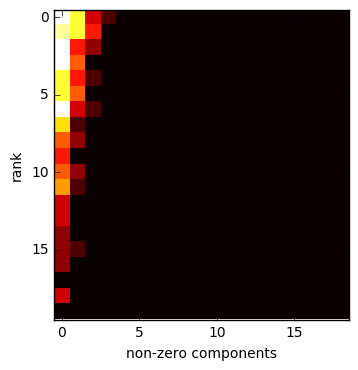

In [18]:
imshow(ps, cmap='hot', interpolation='nearest')
xlabel('non-zero components')
ylabel('rank')

# SPCA 

In [333]:
np.sqrt((300*0.925)**2 + (0.3*290)**2)

290.81824220636503

(290, 310)

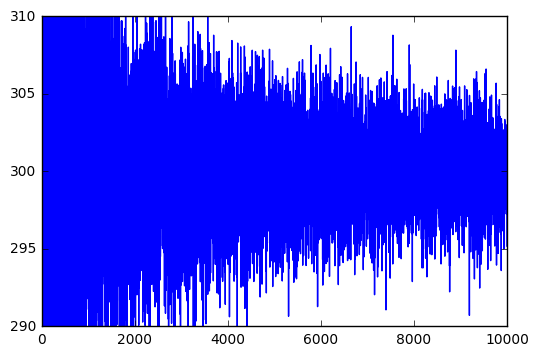

In [382]:
plot([np.random.normal(0,300,size=x).std() for x in range(10000)])
ylim(290,310)

In [397]:
def V1(): return np.random.normal(0,290)
def V2(): return np.random.normal(0,300)
def e(): return np.random.normal(0,1)

def V3(v1, v2, e1): return -0.3*v1 + 0.925*v2 + e1


n_samples = 10000
p = 10

def sample():
    v1 = V1()
    v2 = V2()
    e1 = e()
    r = np.array([v1 for _ in range(4)] + [v2 for _ in range(4)] + [V3(v1,v2,e1) for _ in range(2)])
    r += np.random.normal(0,1,size=p)
    return r.reshape(p,1)

In [398]:
observed = np.array([sample() for _ in range(n_samples)])
observed = observed.reshape((n_samples, p)) # this produces a 10x1000 array

# sampled PCA

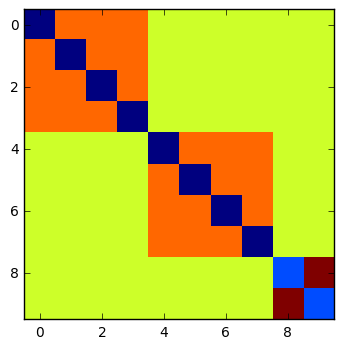

In [399]:
imshow(sigma, interpolation="nearest")

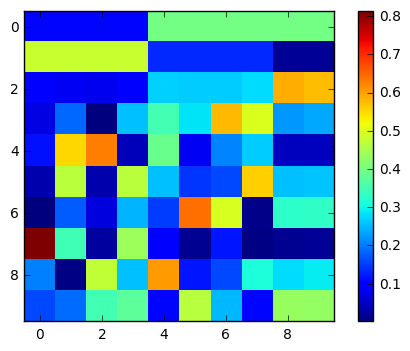

In [400]:
o = observed - observed.mean(axis = 0)
sigma = np.dot(o.T, o) / (n_samples)
U,s,PCA = svd(sigma)
imshow(np.abs(PCA), interpolation="nearest")
_=colorbar()

[ 290.45415324  290.46250847  290.45722518  290.45082172  304.05487681
  304.05183544  304.04389617  304.07028322  295.07696312  295.04404342]


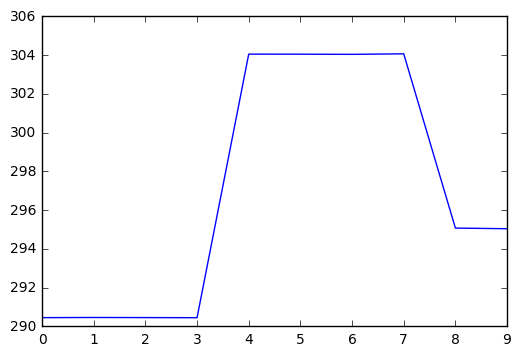

In [401]:
print observed.std(axis = 0)
plot(observed.std(axis = 0))

# SPCA

In [402]:
from sklearn.decomposition import SparsePCA

In [403]:
spca = SparsePCA()
asd = spca.fit(observed)


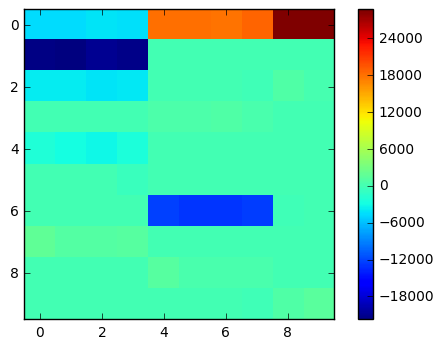

In [404]:
imshow(spca.components_, interpolation="nearest")
colorbar()

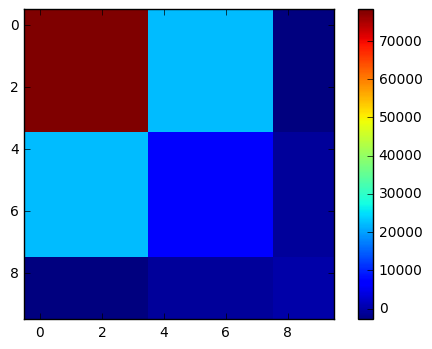

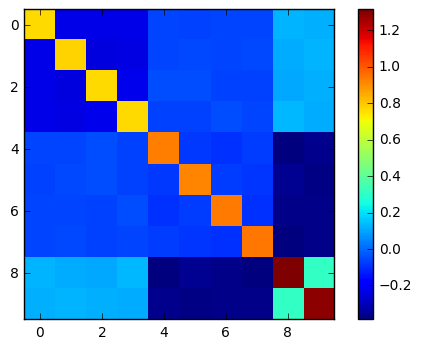

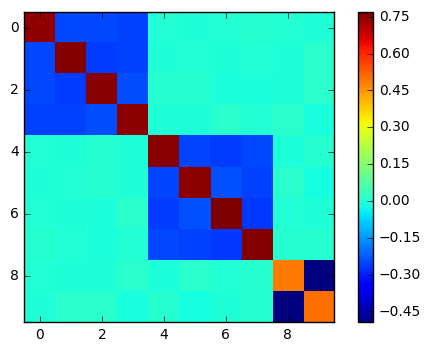

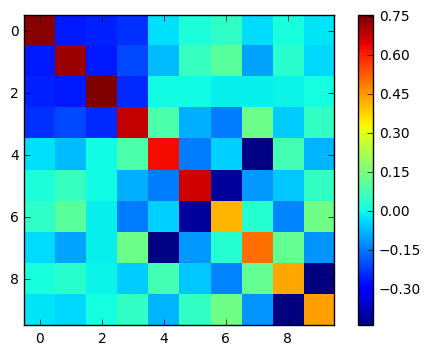

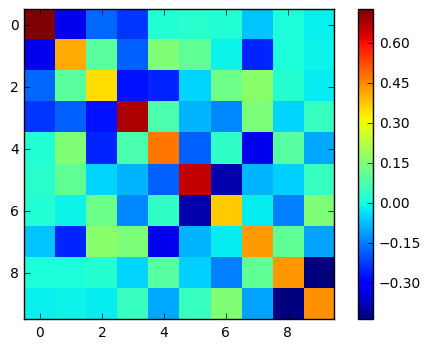

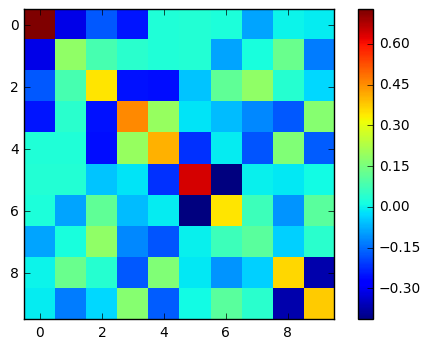

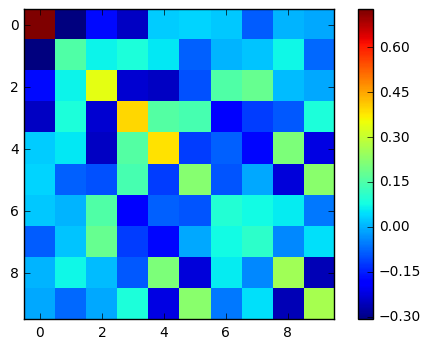

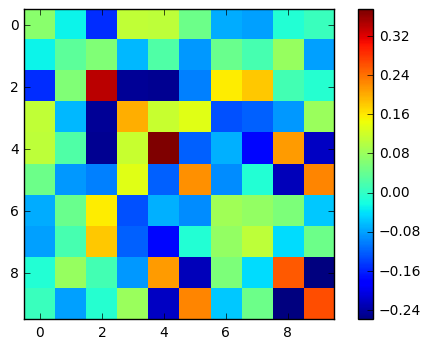

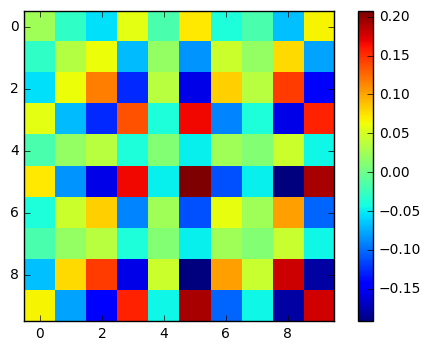

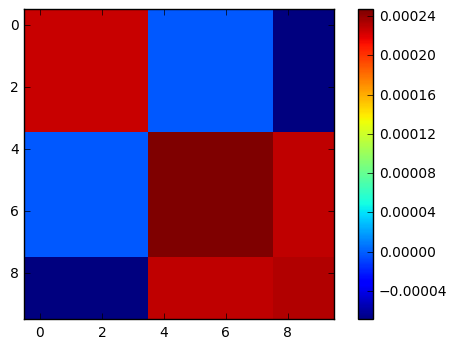

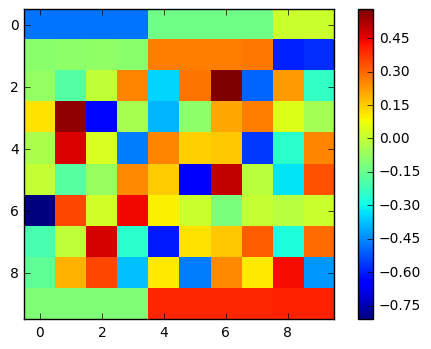

In [408]:
from cvxpy import *
sigma = np.cov(observed.T)
n = sigma.shape[0]
SPCA = []
l = 0
for _ in range(n):
    
    X = Semidef(n) # a n by n positive semidefinite variable for cvxpy
    traceSV = sum([(sigma*X)[i, i] for i in range(n)]) # a cvxpy object
    traceX = sum([X[i, i] for i in range(n)]) # a cvxpy object
    
    obj = Maximize(traceSV - l*norm(X,1))

    constraints = [traceX == 1.0]

    prob = Problem(obj, constraints)
    prob.solve()
    
    sigma -= np.trace(sigma * X.value)* X.value
    
    a,b,c = svd(sigma)
    imshow(sigma, interpolation="nearest")    
    colorbar()
    show()
    
    SPCA.append(c[0])
imshow(SPCA, interpolation="nearest")
_=colorbar()

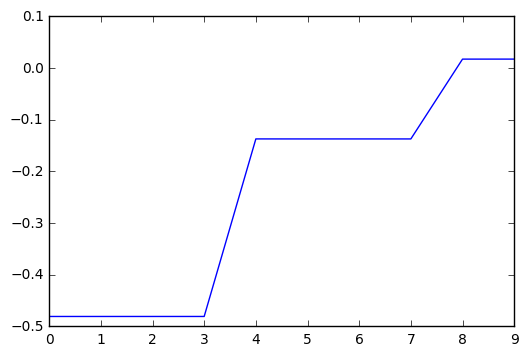

In [412]:
plot(SPCA[0])
plot(PCA[1])

In [330]:
print traceSV

0 + [[  2.66430773e-01  -7.02364330e-01  -7.18859618e-01  -7.16677026e-01
    6.55062303e-01   6.52323237e-01   6.42350167e-01   6.54337678e-01
   -9.96899858e-01  -9.79064288e-01]
 [ -7.02364330e-01  -2.95262426e-06  -7.39536436e-01  -7.13935592e-01
    6.44963185e-01   6.52012269e-01   6.68376859e-01   6.54143047e-01
   -9.92765978e-01  -9.99326717e-01]
 [ -7.18859618e-01  -7.39536436e-01  -4.43924737e-07  -7.10701074e-01
    6.45227764e-01   6.59017377e-01   6.57220404e-01   6.69795939e-01
   -9.99353105e-01  -9.98638094e-01]
 [ -7.16677026e-01  -7.13935592e-01  -7.10701074e-01   2.74605110e-01
    6.61549359e-01   6.43550402e-01   6.40821675e-01   6.43115390e-01
   -9.70402892e-01  -9.89736064e-01]
 [  6.55062303e-01   6.44963185e-01   6.45227764e-01   6.61549359e-01
    8.23668958e-09   5.34470388e-01   5.24374792e-01   4.98468393e-01
   -8.32506140e-01  -8.16602285e-01]
 [  6.52323237e-01   6.52012269e-01   6.59017377e-01   6.43550402e-01
    5.34470388e-01   1.82354071e-08   5.2

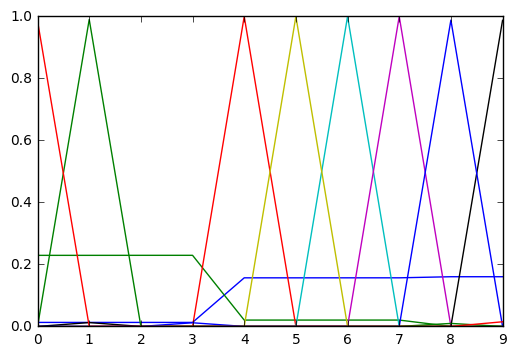

In [265]:
_ = [plot(p) for p in  SPCA]

### compare PCA to SPCA

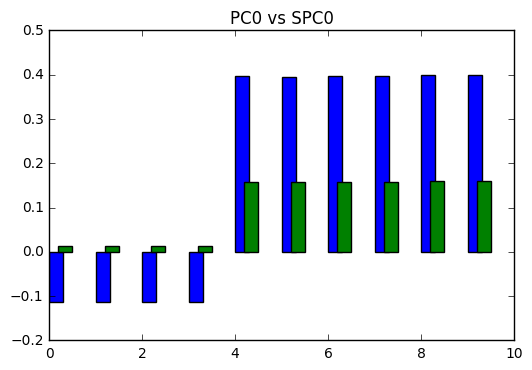

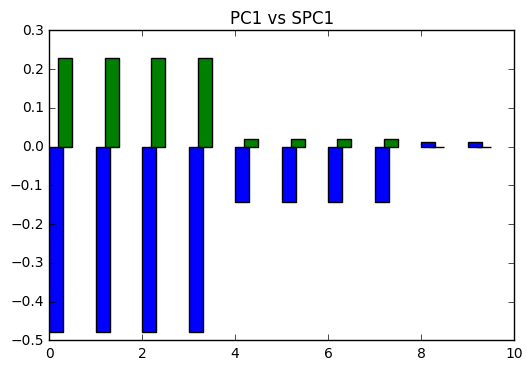

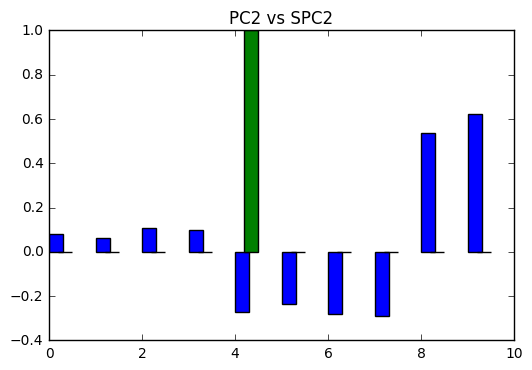

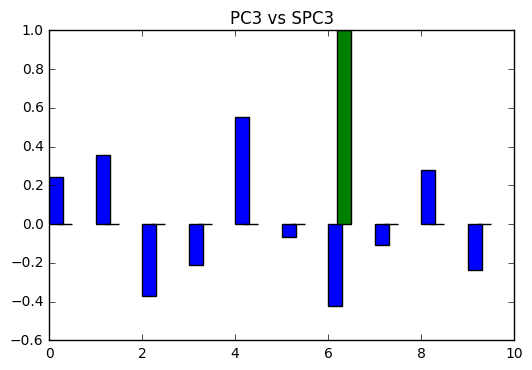

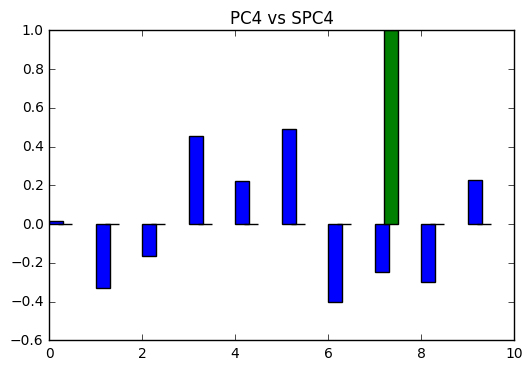

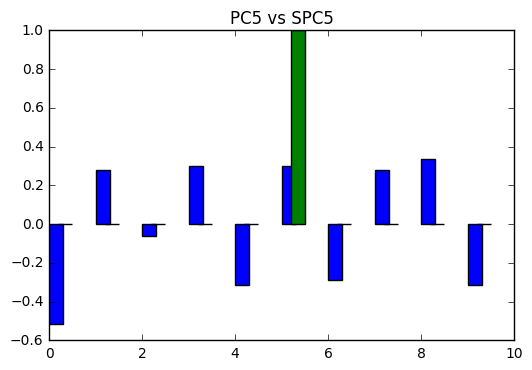

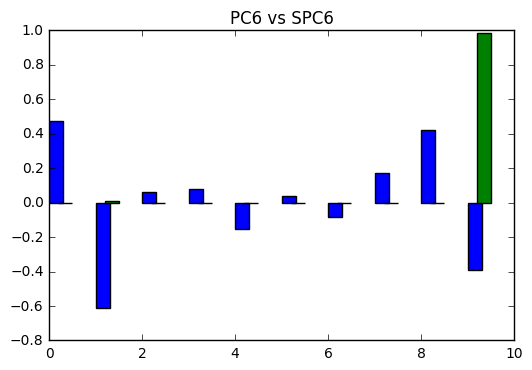

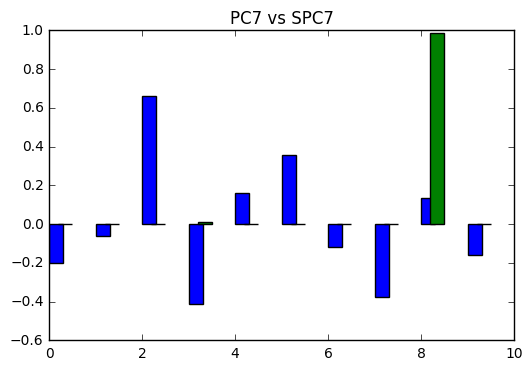

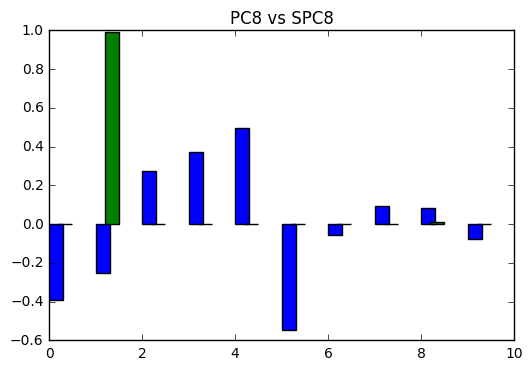

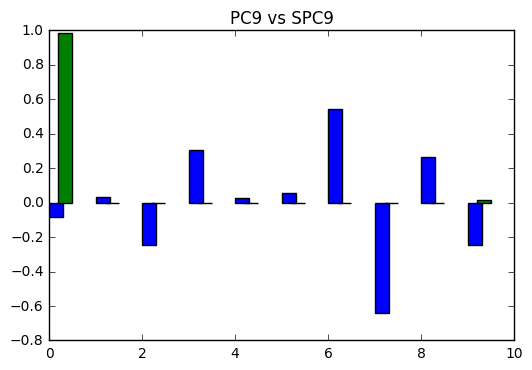

In [266]:
for pc in range(PCA.shape[0]):
    xposPCA = np.array(range(len(PCA)))
    xposSPCA = np.array(range(len(PCA))) + 0.2
    bar(xposPCA,PCA[pc], width = 0.3)
    bar(xposSPCA,SPCA[pc], width = 0.3, color = "green")
    xlim(0,len(PCA))
    title("PC" + str(pc) + " vs SPC" + str(pc))
    show()